In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!unzip /content/drive/MyDrive/data/flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/magnolia/6149135374_62be466003_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._6149135374_62be466003_c.jpg  
  inflating: flowers/magnolia/3435655162_5cd97a06bf_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._3435655162_5cd97a06bf_c.jpg  
  inflating: flowers/magnolia/49914925881_ab2f1cfe20_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._49914925881_ab2f1cfe20_c.jpg  
  inflating: flowers/magnolia/40757927563_d6b0db7487_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._40757927563_d6b0db7487_c.jpg  
  inflating: flowers/magnolia/25862251632_be6c0795b2_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._25862251632_be6c0795b2_c.jpg  
  inflating: flowers/magnolia/3538463489_aff1faafb6_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._3538463489_aff1faafb6_c.jpg  
  inflating: flowers/magnolia/4510011579_75954cff3f_c.jpg  
  inflating: __MACOSX/flowers/magnolia/._4510011579_75954cff3f_c.jpg  
  inflating: flowers/magno

In [49]:
!unzip drive/MyDrive/data/flower_predicting.zip

Archive:  drive/MyDrive/data/flower_predicting.zip
   creating: flower_predicting/
  inflating: flower_predicting/water_lily.webp  
  inflating: __MACOSX/flower_predicting/._water_lily.webp  
  inflating: flower_predicting/sunflower.jpg  
  inflating: __MACOSX/flower_predicting/._sunflower.jpg  
  inflating: flower_predicting/.DS_Store  
  inflating: __MACOSX/flower_predicting/._.DS_Store  
  inflating: flower_predicting/rose.jpg  
  inflating: __MACOSX/flower_predicting/._rose.jpg  
  inflating: flower_predicting/daffodil.jpeg  
  inflating: __MACOSX/flower_predicting/._daffodil.jpeg  
  inflating: flower_predicting/dandelion.jpg  
  inflating: __MACOSX/flower_predicting/._dandelion.jpg  
  inflating: flower_predicting/calendula.jpg  
  inflating: __MACOSX/flower_predicting/._calendula.jpg  
  inflating: flower_predicting/magnolia.webp  
  inflating: __MACOSX/flower_predicting/._magnolia.webp  
  inflating: flower_predicting/iris.jpg  
  inflating: __MACOSX/flower_predicting/._iris.jp

In [50]:
os.remove('flowers/.DS_Store')

In [51]:
os.remove('flower_predicting/.DS_Store')

## Create Dataframe

In [52]:
data_dir = 'flowers'
image_paths = []
labels = []
for class_name in os.listdir(data_dir):
  image_paths.extend([os.path.join(data_dir, class_name, image) for image in os.listdir(os.path.join(data_dir, class_name))])
  labels.extend([class_name for image in os.listdir(os.path.join(data_dir, class_name))])

In [53]:
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [54]:
df.head()

,image_path,label
0,flowers/bellflower/48098758727_bfe08cd1f0_c.jpg,bellflower
1,flowers/bellflower/9203748758_06e2086537_c.jpg,bellflower
2,flowers/bellflower/50125402332_8ca34c5350_c.jpg,bellflower
3,flowers/bellflower/9267974441_ec8d77618c_c.jpg,bellflower
4,flowers/bellflower/27805667777_19c1d8898e_c.jpg,bellflower


## Explore Data

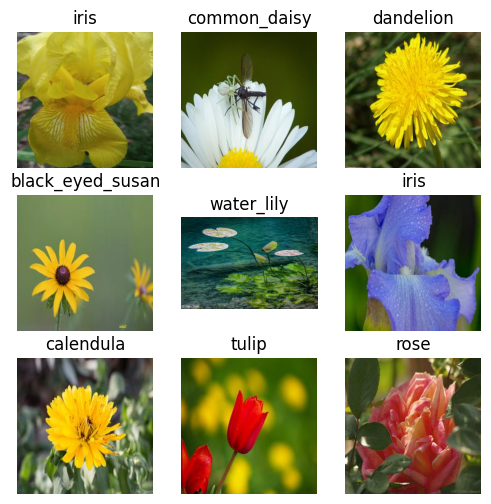

In [55]:
fig = plt.figure(figsize=(6, 6))

for i in range(9):
  random_index = np.random.randint(0, len(df))
  image_path = df.iloc[random_index]['image_path']
  image = plt.imread(image_path)
  label = df.iloc[random_index]['label']

  fig.add_subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

## Prepare Data

In [56]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
test, val = train_test_split(test, test_size=0.5, random_state=42)

In [57]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_iter = train_gen.flow_from_dataframe(
    train,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_iter = val_gen.flow_from_dataframe(
    val,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

test_iter = test_gen.flow_from_dataframe(
    test,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=1,
    shuffle=False
)

Found 12592 validated image filenames belonging to 16 classes.
Found 1574 validated image filenames belonging to 16 classes.
Found 1574 validated image filenames belonging to 16 classes.


In [58]:
label_map = train_iter.class_indices
classes = list(label_map.keys())

## Build Model

In [59]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [61]:
history = model.fit(train_iter, epochs=30, validation_data=val_iter)

Epoch 1/30
394/394 [==============================] - 208s 508ms/step - loss: 1.9138 - accuracy: 0.3493 - val_loss: 1.4178 - val_accuracy: 0.5324
Epoch 2/30
394/394 [==============================] - 201s 510ms/step - loss: 1.4431 - accuracy: 0.5106 - val_loss: 1.1800 - val_accuracy: 0.5934
Epoch 3/30
394/394 [==============================] - 206s 522ms/step - loss: 1.2647 - accuracy: 0.5750 - val_loss: 1.0496 - val_accuracy: 0.6341
Epoch 4/30
394/394 [==============================] - 201s 511ms/step - loss: 1.1350 - accuracy: 0.6159 - val_loss: 0.9405 - val_accuracy: 0.6811
Epoch 5/30
394/394 [==============================] - 200s 507ms/step - loss: 1.0134 - accuracy: 0.6568 - val_loss: 0.9103 - val_accuracy: 0.6836
Epoch 6/30
394/394 [==============================] - 196s 497ms/step - loss: 0.9431 - accuracy: 0.6866 - val_loss: 0.8157 - val_accuracy: 0.7243
Epoch 7/30
394/394 [==============================] - 185s 470ms/step - loss: 0.8738 - accuracy: 0.7078 - val_loss: 0.8157 -

## Visualize Results

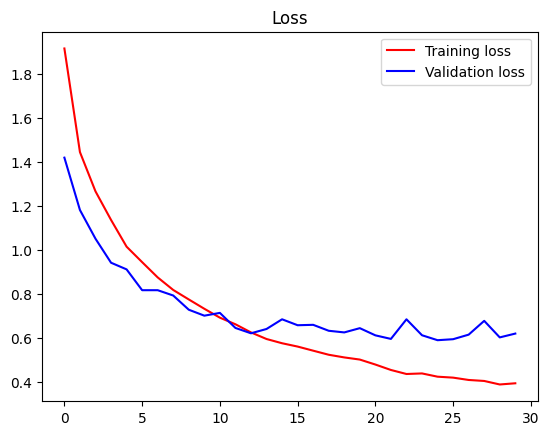

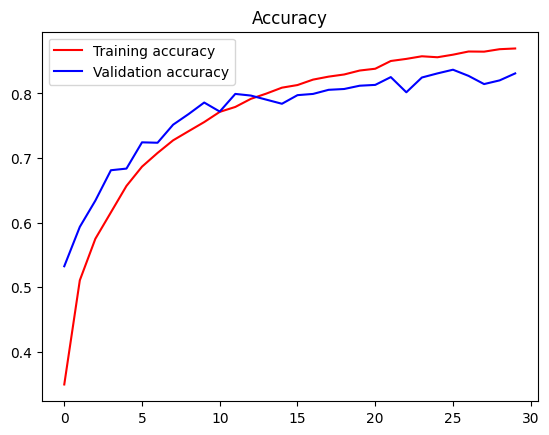

In [62]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Evaluate Results

In [63]:
model.evaluate(test_iter)

1574/1574 [==============================] - 8s 5ms/step - loss: 0.5795 - accuracy: 0.8297


[0.5794814825057983, 0.8297331929206848]

In [64]:
predictions = model.predict(test_iter)

1574/1574 [==============================] - 7s 4ms/step


In [65]:
predictions = [np.argmax(prediction) for prediction in predictions]

In [66]:
predictions_df = pd.DataFrame()
predictions_df['image_path'] = test_iter.filenames
predictions_df['label'] = test_iter.labels
predictions_df['prediction'] = predictions

predictions_df.head()

,image_path,label,prediction
0,flowers/water_lily/13076859873_b07bf5dd55_c.jpg,15,15
1,flowers/california_poppy/7318391916_161e2b41c0...,4,4
2,flowers/astilbe/14439714103_d28e557603_c.jpg,0,11
3,flowers/sunflower/41588018980_a1c34cb58d_c.jpg,13,13
4,flowers/astilbe/3836679586_498541a6f0_c.jpg,0,0


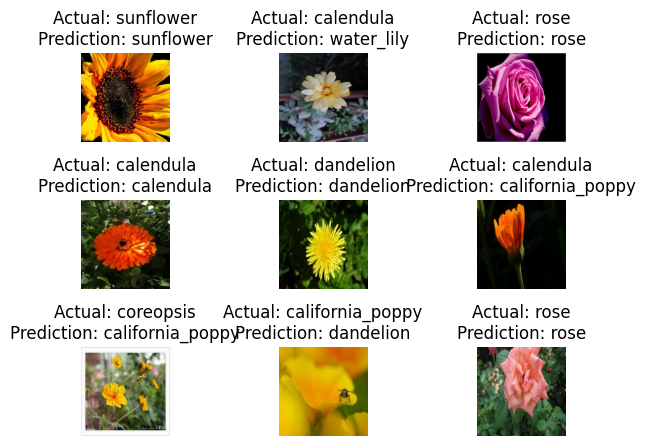

In [71]:
for i in range(9):
  random_index = np.random.randint(0, len(predictions_df))
  image_path = predictions_df['image_path'].iloc[random_index]
  image = plt.imread(image_path)

  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(image)

  label_index = predictions_df['label'].iloc[random_index]
  prediction_index = predictions_df['prediction'].iloc[random_index]
  label = classes[label_index]
  prediction = classes[prediction_index]

  plt.title(f'Actual: {label}\nPrediction: {prediction}')
  plt.axis('off')

## Save Model

In [72]:
save_model(model, '/content/drive/MyDrive/Colab Notebooks/models/flower_model_3.h5')

<ipython-input-72-113a165df1e1>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, '/content/drive/MyDrive/Colab Notebooks/models/flower_model_3.h5')


## Predict

In [73]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/models/flower_model_3.h5')
loaded_model.evaluate(test_iter)

1574/1574 [==============================] - 8s 5ms/step - loss: 0.5795 - accuracy: 0.8297


[0.5794814825057983, 0.8297331929206848]

In [74]:
def predict_image(image_path, model):
  img = plt.imread(image_path)
  resized = tf.image.resize(img, (224, 224))
  expanded = np.expand_dims(resized/255, axis=0)

  raw_prediction = model.predict(expanded)
  int_prediction = np.argmax(raw_prediction)
  prediction = classes[int_prediction]

  return prediction

1/1 [==============================] - 0s 18ms/step


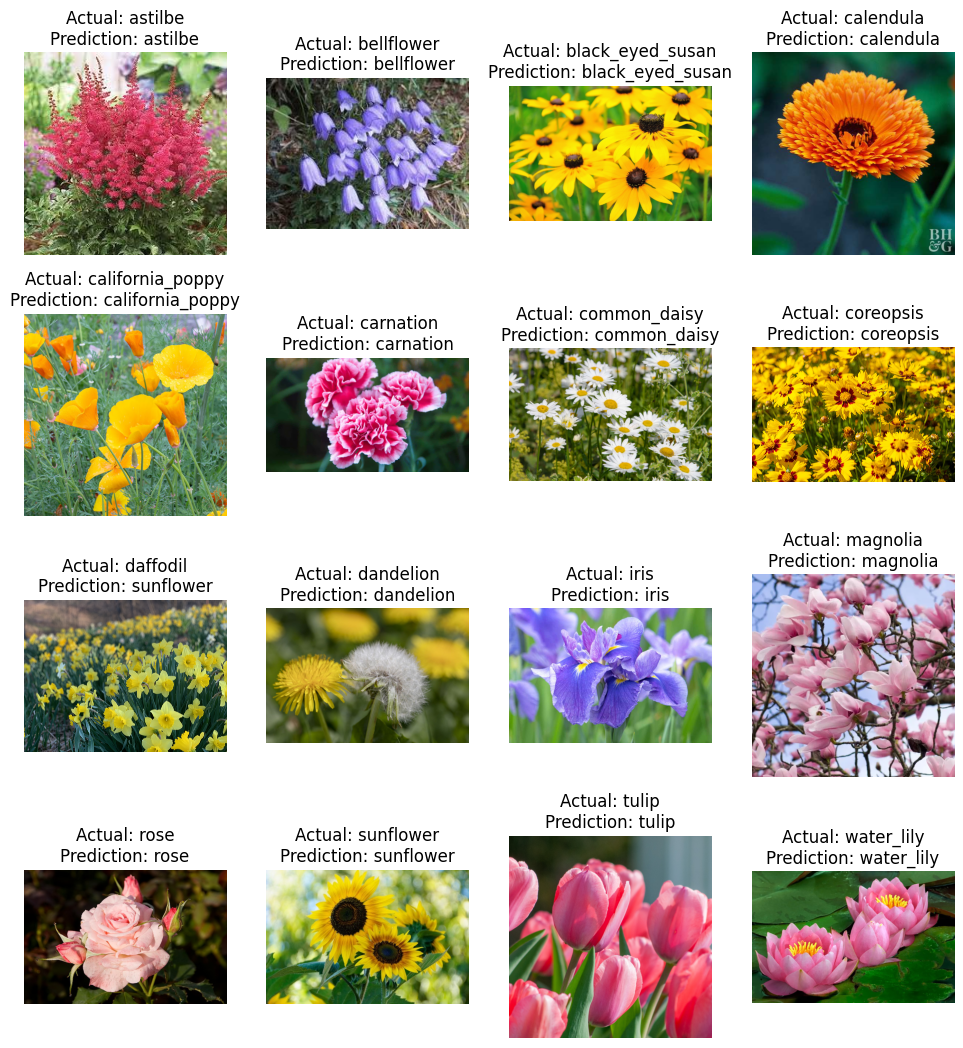

In [78]:
data_dir = 'flower_predicting'
paths = [os.path.join(data_dir, image_name) for image_name in os.listdir(data_dir)]
paths.sort()
labels = ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis',
          'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']

fig = plt.figure(figsize=(12, 13))

for i in range(16):
    image_path = paths[i]
    image = plt.imread(image_path)
    label = labels[i]
    prediction = predict_image(image_path, loaded_model)

    fig.add_subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(f'Actual: {label}\nPrediction: {prediction}')
    plt.axis('off')